In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
unpickle = lambda filename: pickle.Unpickler(open(filename, 'rb'), encoding = 'latin1').load()

data_batches = [
    unpickle("cifar-10-batches-py/data_batch_1"),
    unpickle("cifar-10-batches-py/data_batch_2"),
    unpickle("cifar-10-batches-py/data_batch_3"),
    unpickle("cifar-10-batches-py/data_batch_4"),
    unpickle("cifar-10-batches-py/data_batch_5")]

test_batch = unpickle("cifar-10-batches-py/test_batch")

print(data_batches[0].keys())
print(test_batch.keys())

dict_keys(['batch_label', 'filenames', 'data', 'labels'])
dict_keys(['batch_label', 'filenames', 'data', 'labels'])


In [3]:
image_size = 32
features_size = 3072

train_images = np.vstack([x["data"] for x in data_batches]).astype("float32")
validation_images = test_batch["data"].astype("float32")

train_labels = np.hstack([x["labels"] for x in data_batches])
validation_labels = np.array(test_batch["labels"])

print(train_images.shape)
print(validation_images.shape)
print(train_labels.shape)
print(validation_labels.shape)

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


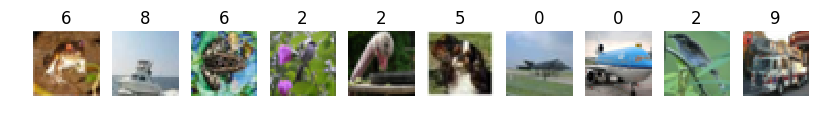

In [4]:
convert_image = lambda x: x.reshape((3, image_size, image_size)).swapaxes(0, 1).swapaxes(1, 2).astype('uint8')

for i in range(0, 10):
    plt.subplot(1, 10, i + 1)
    plt.title(str(train_labels[i * 100]))
    plt.imshow(convert_image(train_images[i * 100]))
    plt.axis('off')

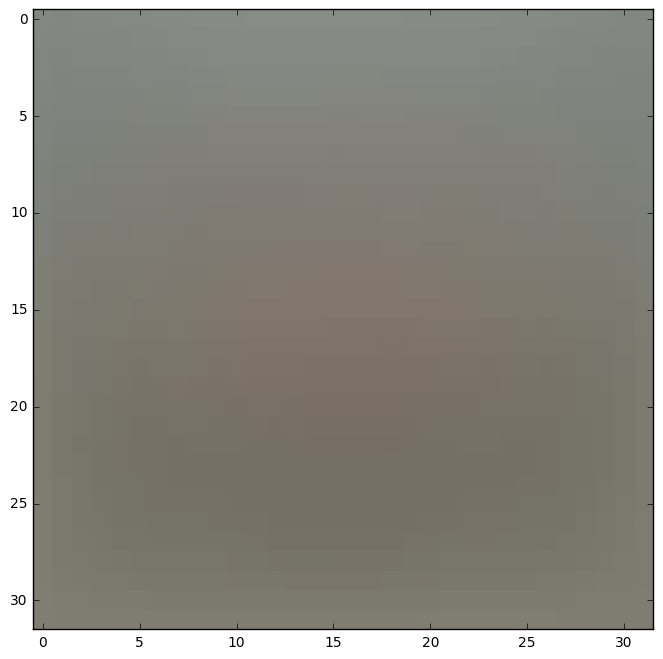

In [5]:
mean_image = np.mean(train_images, axis = 0)
plt.imshow(convert_image(mean_image))

train_images = (train_images - mean_image)
validation_images = (validation_images - mean_image)

In [6]:
%%time

classes_count = 10
hidden_neurons = 200
minibatch_size = 200
regularization_factor = 0.001
learning_rate = 0.01
momentum_decay = 0.9

# 3 relu layers, 1 output softmax layer
# momentum was added to speed up learning

W1 = np.random.uniform(high = 1.0 / features_size, size = (features_size, hidden_neurons))
b1 = np.zeros(shape = (hidden_neurons,))
W2 = np.random.uniform(high = 1.0 / hidden_neurons, size = (hidden_neurons, hidden_neurons))
b2 = np.zeros(shape = (hidden_neurons,))
W3 = np.random.uniform(high = 1.0 / hidden_neurons, size = (hidden_neurons, hidden_neurons))
b3 = np.zeros(shape = (hidden_neurons,))
W4 = np.random.uniform(high = 1.0 / hidden_neurons, size = (hidden_neurons, classes_count))
b4 = np.zeros(shape = (classes_count,))

W1m = np.zeros_like(W1)
b1m = np.zeros_like(b1)
W2m = np.zeros_like(W2)
b2m = np.zeros_like(b2)
W3m = np.zeros_like(W3)
b3m = np.zeros_like(b3)
W4m = np.zeros_like(W4)
b4m = np.zeros_like(b4)

learning_history = []

for epoch in range(10000):
    choice = np.random.choice(train_images.shape[0], minibatch_size)
    X = train_images[choice]
    y = train_labels[choice]
    
    # forward pass
    H0 = X
    H1 = np.maximum(np.dot(H0, W1) + b1, 0)
    H2 = np.maximum(np.dot(H1, W2) + b2, 0)
    H3 = np.maximum(np.dot(H2, W3) + b3, 0)
    H4 = np.dot(H3, W4) + b4
    
    scores = H4 - np.max(H4, axis = 1, keepdims = True)
    probs = np.exp(scores)
    probs /= np.sum(probs, axis = 1, keepdims = True)
    labels = np.argmax(probs, axis = 1)
    
    accuracy = np.mean(labels == y)    

    loss = np.sum(-np.log(probs[range(minibatch_size), y])) / minibatch_size
    loss += 0.5 * regularization_factor * (np.sum(W2 * W2))
    loss += 0.5 * regularization_factor * (np.sum(W2 * W2))
    loss += 0.5 * regularization_factor * (np.sum(W3 * W3))
    loss += 0.5 * regularization_factor * (np.sum(W4 * W4))
    
    if epoch % 10 == 0:
        H0v = validation_images
        H1v = np.maximum(np.dot(H0v, W1) + b1, 0)
        H2v = np.maximum(np.dot(H1v, W2) + b2, 0)
        H3v = np.maximum(np.dot(H2v, W3) + b3, 0)
        H4v = np.dot(H3v, W4) + b4
        validation_pred = np.argmax(H4v, axis = 1)
        validation_accuracy = np.mean(validation_labels == validation_pred)
        learning_history.append((accuracy, validation_accuracy, loss))

        if epoch % 200 == 0:
            print('epoch %d: accuracy = %f, validation_accuracy = %f, loss = %f' % (epoch, accuracy, validation_accuracy, loss))

    # backprop
    # layer 4
    dL_dH4 = np.array(probs)
    dL_dH4[range(minibatch_size), y] -= 1
    dL_dH4 /= minibatch_size

    dH4_dW4 = np.array(H3)

    dL_dW4 = np.dot(dH4_dW4.T, dL_dH4)
    dL_dW4 += regularization_factor * W4
    dL_db4 = np.sum(dL_dH4, axis = 0)
    
    # layer 3
    dH3_dW3 = np.array(H2)
    dH3_db3 = np.ones(shape = H2.shape[0])  
    
    dH4_dH3 = np.array(W4)
    
    dL_dH3 = np.dot(dL_dH4, dH4_dH3.T)
    dL_dH3[H3 <= 0] = 0
    
    dL_dW3 = np.dot(dH3_dW3.T, dL_dH3)
    dL_dW3 += regularization_factor * W3
    dL_db3 = np.dot(dH3_db3.T, dL_dH3)

    # layer 2
    dH2_dW2 = np.array(H1)
    dH2_db2 = np.ones(shape = H1.shape[0])  
    
    dH3_dH2 = np.array(W3)
    
    dL_dH2 = np.dot(dL_dH3, dH3_dH2.T)
    dL_dH2[H2 <= 0] = 0
    
    dL_dW2 = np.dot(dH2_dW2.T, dL_dH2)
    dL_dW2 += regularization_factor * W2
    dL_db2 = np.dot(dH2_db2.T, dL_dH2)

    # layer 1
    dH1_dW1 = np.array(H0)
    dH1_db1 = np.ones(shape = H0.shape[0])
    
    dH2_dH1 = np.array(W2)
    
    dL_dH1 = np.dot(dL_dH2, dH2_dH1.T)
    dL_dH1[H1 <= 0] = 0
    
    dL_dW1 = np.dot(dH1_dW1.T, dL_dH1)
    dL_dW1 += regularization_factor * W1
    dL_db1 = np.dot(dH1_db1.T, dL_dH1)
    
    # momentum
    W4m = W4m * momentum_decay + dL_dW4
    b4m = b4m * momentum_decay + dL_db4
    W3m = W3m * momentum_decay + dL_dW3
    b3m = b3m * momentum_decay + dL_db3
    W2m = W2m * momentum_decay + dL_dW2
    b2m = b2m * momentum_decay + dL_db2
    W1m = W1m * momentum_decay + dL_dW1
    b1m = b1m * momentum_decay + dL_db1

    # sgd step
    W4 += - learning_rate * W4m
    b4 += - learning_rate * b4m
    W3 += - learning_rate * W3m
    b3 += - learning_rate * b3m
    W2 += - learning_rate * W2m
    b2 += - learning_rate * b2m
    W1 += - learning_rate * W1m
    b1 += - learning_rate * b1m


epoch 0: accuracy = 0.045000, validation_accuracy = 0.066300, loss = 2.310931
epoch 200: accuracy = 0.180000, validation_accuracy = 0.201400, loss = 2.047279
epoch 400: accuracy = 0.230000, validation_accuracy = 0.305500, loss = 2.009736
epoch 600: accuracy = 0.385000, validation_accuracy = 0.406900, loss = 1.734117
epoch 800: accuracy = 0.455000, validation_accuracy = 0.425600, loss = 1.544962
epoch 1000: accuracy = 0.485000, validation_accuracy = 0.456400, loss = 1.469780
epoch 1200: accuracy = 0.440000, validation_accuracy = 0.439400, loss = 1.473056
epoch 1400: accuracy = 0.530000, validation_accuracy = 0.459500, loss = 1.393449
epoch 1600: accuracy = 0.485000, validation_accuracy = 0.464400, loss = 1.486044
epoch 1800: accuracy = 0.605000, validation_accuracy = 0.469300, loss = 1.192215
epoch 2000: accuracy = 0.485000, validation_accuracy = 0.466800, loss = 1.427182
epoch 2200: accuracy = 0.555000, validation_accuracy = 0.477700, loss = 1.339373
epoch 2400: accuracy = 0.580000, va

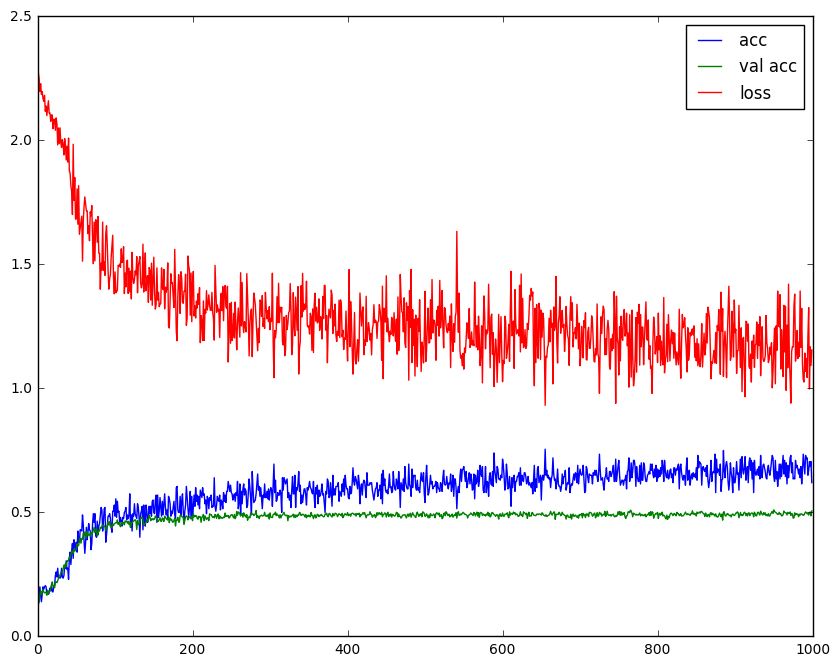

In [7]:
plt.plot(learning_history)
plt.legend(("acc", "val acc", "loss"))

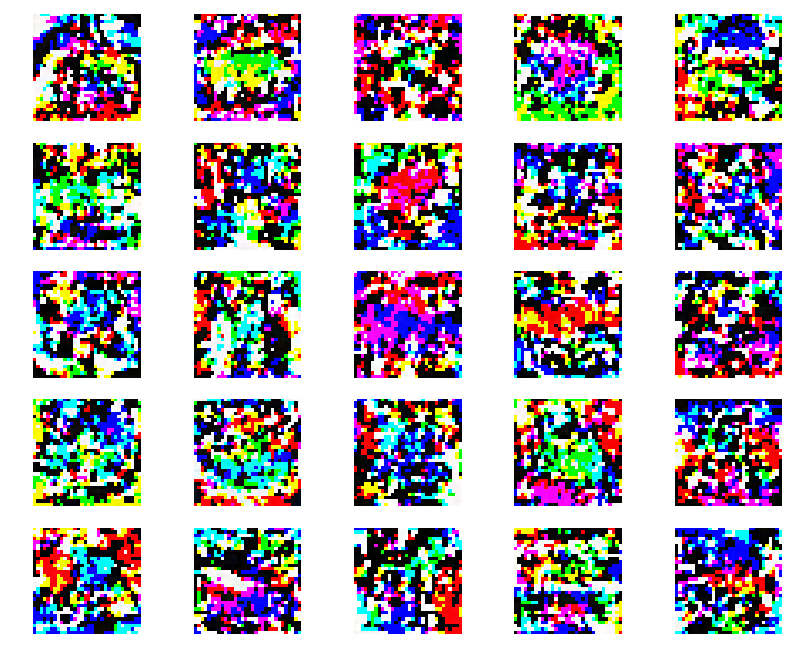

In [9]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(convert_image(W1[:, i * 5] * 256))
    plt.axis('off')

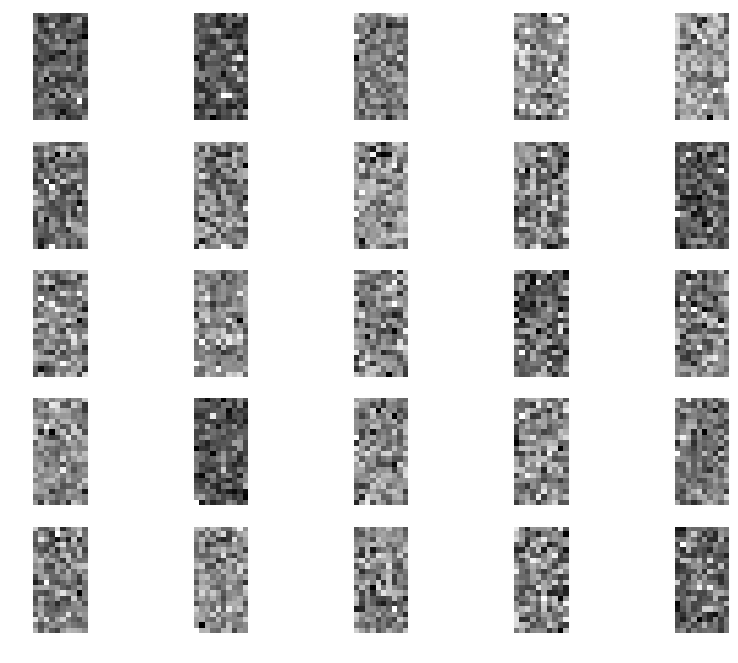

In [11]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(W2[:, i * 5].reshape(20, 10))
    plt.axis('off')

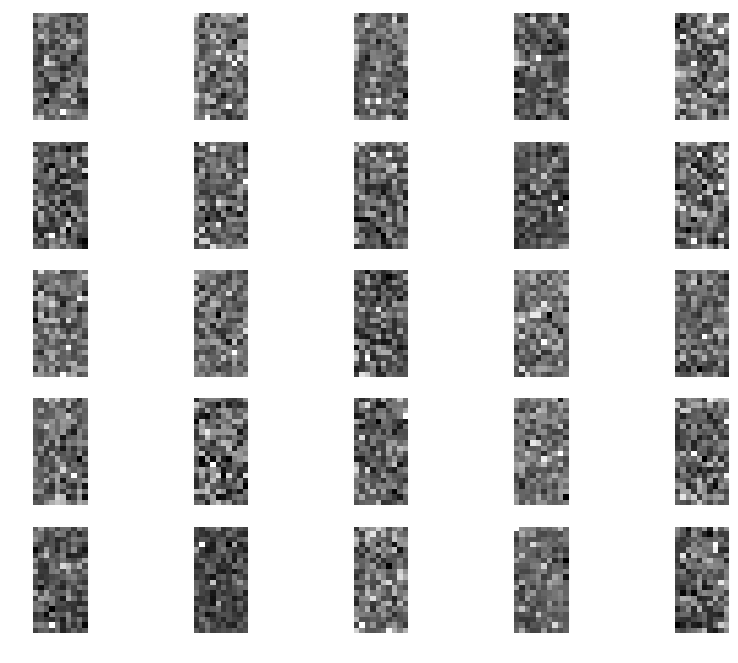

In [12]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(W3[:, i * 5].reshape(20, 10))
    plt.axis('off')

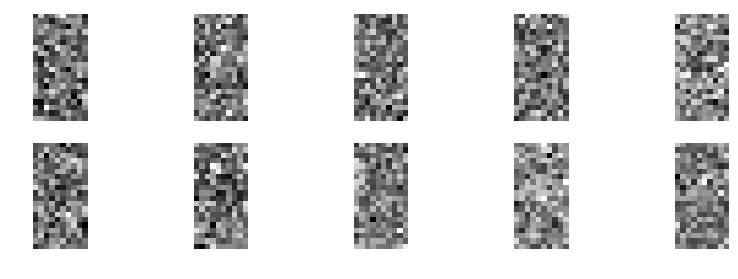

In [13]:
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(W4[:, i].reshape(20, 10))
    plt.axis('off')